In [1]:
import pandas as pd
import mne
from scipy.signal import welch
from scipy.integrate import simps
import numpy as np


# Identifing redundant channels

To identify the redundant channels, I will compute the correlation matrix of the EEG data across channels. The correlation matrix indicates the degree of similarity between pairs of channels, with high correlations indicating redundancy.

Channels names are taken from here: https://github.com/mne-tools/mne-python/blob/main/mne/channels/data/montages/biosemi32.txt

## Reading the data

In [2]:
df = pd.read_csv('first.csv').T
ch_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']

col0 = list(df.index)
df.index = [i for i in range(df.shape[0])]
df.insert(0, 'Channel 0', col0)

col_names = list(df.columns)
for i, name in enumerate(col_names):
    col_names[i] = ch_names[i]
df.columns = col_names

df

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,-6.72739269471523e-06,1.361943e-05,-4.171621e-06,-0.000002,-0.000006,-1.001298e-05,-7.595006e-07,-0.000001,-1.664115e-06,-0.000001,...,8.931591e-06,0.000007,8.767896e-07,0.000004,0.000009,0.000012,0.000013,0.000007,0.000013,0.000017
1,-1.65505849503899e-06,6.889464e-06,-6.125145e-06,-0.000005,-0.000008,-9.962646e-06,-2.828937e-06,-0.000002,-1.277049e-06,-0.000003,...,8.339754e-06,0.000006,2.154500e-06,0.000004,0.000009,0.000011,0.000011,0.000009,0.000014,0.000015
2,3.33864235901053e-06,9.700098e-08,-7.833986e-06,-0.000009,-0.000010,-9.677961e-06,-4.739417e-06,-0.000002,-8.981117e-07,-0.000004,...,7.823200e-06,0.000006,3.621418e-06,0.000005,0.000009,0.000011,0.000009,0.000011,0.000014,0.000013
3,8.20944109862389e-06,-6.693844e-06,-9.122083e-06,-0.000011,-0.000011,-8.995215e-06,-6.339069e-06,-0.000002,-5.735459e-07,-0.000005,...,7.470099e-06,0.000005,5.261176e-06,0.000006,0.000010,0.000010,0.000008,0.000013,0.000015,0.000012
4,1.29178488867151e-05,-1.323892e-05,-9.923132e-06,-0.000012,-0.000012,-7.834776e-06,-7.496405e-06,-0.000002,-3.975981e-07,-0.000006,...,7.376293e-06,0.000004,6.758102e-06,0.000007,0.000011,0.000011,0.000007,0.000016,0.000017,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,3.39628893243955e-05,2.266228e-05,-8.578327e-08,0.000009,0.000005,1.275403e-06,5.167733e-06,-0.000008,1.656066e-06,0.000004,...,-5.623219e-06,-0.000002,-8.136743e-06,-0.000012,-0.000007,-0.000015,-0.000009,-0.000027,-0.000022,-0.000021
10008,3.22877022686518e-05,2.305968e-05,-5.265663e-07,0.000007,0.000003,-5.690372e-07,4.669743e-06,-0.000008,1.104184e-06,0.000002,...,-5.715184e-06,-0.000002,-1.129653e-05,-0.000012,-0.000008,-0.000015,-0.000009,-0.000029,-0.000022,-0.000020
10009,3.01690978849432e-05,2.151574e-05,-2.209937e-07,0.000006,0.000003,-1.868614e-07,4.604571e-06,-0.000007,1.720460e-06,0.000002,...,-4.849402e-06,-0.000002,-1.135260e-05,-0.000011,-0.000007,-0.000013,-0.000009,-0.000026,-0.000020,-0.000018
10010,2.76408663058494e-05,1.841337e-05,7.469967e-07,0.000006,0.000004,1.977762e-06,4.909210e-06,-0.000005,3.412971e-06,0.000004,...,-3.098146e-06,-0.000002,-8.489119e-06,-0.000008,-0.000005,-0.000010,-0.000008,-0.000020,-0.000016,-0.000015


## Calculating correlation

In [3]:
corr = df.corr()
corr

,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,P7,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
AF3,1.000000,0.158903,0.222030,0.173756,0.086333,0.410472,0.103112,0.172223,0.222142,0.175788,...,0.096097,-0.030945,-0.116972,-0.081193,-0.084717,-0.060322,-0.075503,-0.191165,-0.255849,-0.197125
F7,0.158903,1.000000,0.548327,0.515710,0.390930,0.732094,0.573184,0.574894,0.514736,0.453467,...,0.117326,-0.176049,0.049781,0.094146,0.027161,-0.017066,-0.140506,-0.128236,-0.254861,-0.249606
F3,0.222030,0.548327,1.000000,0.743206,0.540080,0.552931,0.388168,0.649611,0.764612,0.690343,...,0.375003,0.091149,0.213894,0.363824,0.356848,0.299480,0.142715,0.051822,0.022198,0.020218
FC1,0.173756,0.515710,0.743206,1.000000,0.763713,0.640246,0.346665,0.680781,0.931285,0.947254,...,0.504555,0.200945,0.263135,0.459041,0.480735,0.409191,0.235676,0.099117,0.076427,0.080289
FC5,0.086333,0.390930,0.540080,0.763713,1.000000,0.565419,0.247429,0.478244,0.668306,0.785190,...,0.418483,0.184737,0.146497,0.281214,0.316486,0.302572,0.192492,0.037759,0.014954,0.043703
T7,0.410472,0.732094,0.552931,0.640246,0.565419,1.000000,0.301333,0.487615,0.570505,0.625014,...,0.440769,0.187847,-0.071207,0.034964,0.087687,0.158346,0.104685,-0.172836,-0.239041,-0.163191
C3,0.103112,0.573184,0.388168,0.346665,0.247429,0.301333,1.000000,0.535735,0.380490,0.316331,...,0.035971,-0.228758,0.277634,0.252171,0.138451,0.043809,-0.099964,0.077107,-0.029777,-0.087418
CP1,0.172223,0.574894,0.649611,0.680781,0.478244,0.487615,0.535735,1.000000,0.758498,0.671186,...,0.412502,0.081342,0.375457,0.530968,0.484071,0.378475,0.185319,0.180467,0.135539,0.085651
CP5,0.222142,0.514736,0.764612,0.931285,0.668306,0.570505,0.380490,0.758498,1.000000,0.936472,...,0.590031,0.240053,0.383108,0.632637,0.649207,0.543275,0.321185,0.206894,0.198944,0.179002
P7,0.175788,0.453467,0.690343,0.947254,0.785190,0.625014,0.316331,0.671186,0.936472,1.000000,...,0.639728,0.305099,0.346643,0.578524,0.627760,0.565444,0.368860,0.198531,0.205956,0.203241


## Analyzing the correlation data

Note that if the correlation between two channels is higher than 0.9, this mean that they have high correlation and one of them is redundant.

In [4]:
redundant_channels = []
freq = {}
threshold = 0.9
for i, channel in enumerate(corr):
    values = corr[channel]
    for j, value in enumerate(values):
        if i != j and value > threshold and (ch_names[i+1], ch_names[j+1]) not in redundant_channels and (ch_names[j+1], ch_names[i+1]) not in redundant_channels:
            redundant_channels.append((ch_names[i+1], ch_names[j+1]))
            if freq.get(ch_names[i+1]):
                freq[ch_names[i+1]] += 1
            else:
                freq[ch_names[i+1]] = 1

            if freq.get(ch_names[j+1]):
                freq[ch_names[j+1]] += 1
            else:
                freq[ch_names[j+1]] = 1
redundant_channels

[('FC1', 'CP5'),
 ('FC1', 'P7'),
 ('CP5', 'P7'),
 ('CP5', 'Oz'),
 ('P7', 'Oz'),
 ('O1', 'Oz'),
 ('O1', 'CP6'),
 ('Oz', 'CP6'),
 ('Oz', 'CP2'),
 ('O2', 'CP2'),
 ('O2', 'C4'),
 ('P8', 'FC2'),
 ('CP6', 'CP2'),
 ('CP6', 'FC2'),
 ('CP6', 'F4'),
 ('CP2', 'F4'),
 ('CP2', 'F8'),
 ('C4', 'F8'),
 ('FC2', 'F4'),
 ('F4', 'F8'),
 ('Fp2', 'Fz')]

And to know that most redundant ones, which will be the ones that are correlated with more channels, I calculated their frequencies and sorted them.

In [5]:
sorted_freq = sorted(freq.items(), key=lambda x:x[1], reverse=True)
sorted_freq

[('Oz', 5),
 ('CP6', 5),
 ('CP2', 5),
 ('F4', 4),
 ('CP5', 3),
 ('P7', 3),
 ('FC2', 3),
 ('F8', 3),
 ('FC1', 2),
 ('O1', 2),
 ('O2', 2),
 ('C4', 2),
 ('P8', 1),
 ('Fp2', 1),
 ('Fz', 1)]

# Selecting two channels with key activity

In [6]:
AF3 = df['AF3']

F3 = df['F3']

ch_data = [AF3.values, F3.values]

info = mne.create_info(ch_names=['AF3', 'F3'], sfreq=1000, ch_types='eeg')

AF3_F3 = mne.io.RawArray(ch_data, info)

montage = mne.channels.make_standard_montage('biosemi32')
AF3_F3.set_montage(montage, match_alias=True)

Creating RawArray with float64 data, n_channels=2, n_times=10012
    Range : 0 ... 10011 =      0.000 ...    10.011 secs
Ready.


<RawArray | 2 x 10012 (10.0 s), ~166 kB, data loaded>

In [7]:
AF3_F3_psd = AF3_F3.compute_psd()

AF3_F3_psd.plot_topomap()
AF3_F3_psd.plot()
AF3_F3.plot()

AttributeError: 'RawArray' object has no attribute 'compute_psd'

As we can see from the above, the activity of the channels AF3, and F3 is mostly happening in the frontal lobe, which is responsible for the higher mental functions such as planning, and concentration

# Identifing key frequencies range

To identify the key frequency range I will use band power, I will compute the power of the EEG channel within different frequency bands of interest, such as alpha, beta, theta, and delta. This can be done by integrating the power spectral density (PSD) over the corresponding frequency range for each band. The resulting values provide estimates of the amount of activity within each frequency band, which can be used to identify the key frequency range for the selected channel. The frequency band with the highest band power is often considered the dominant frequency range or peak frequency.

In [23]:
def bandpower(data, sf, band, window_sec=None, relative=False):

    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)

    return bp

freqs_bands = {
    'gamma': [25, 140],
    'beta': [13, 32],
    'alpha': [8, 13],
    'theta': [4, 8],
    'delta': [0.5, 4]
}

# Selecting 2 channels with key activity
channels = [df['AF3'], df['F3']]
channels_names = ['AF3', 'F3']

# Analyzing the power of each frequency range for each channel
for i, channel in enumerate(channels):
    print(f'Info about {channels_names[i]}:')
    for key, value in freqs_bands.items():
        bp = bandpower(channel, 1000, value, 5, True)
        bp = round(bp*100, 2)
        print(f'{key} has {bp}% of the pawer of the channel')
    print()



Info about AF3:
gamma has 52.87% of the pawer of the channel
beta has 29.57% of the pawer of the channel
alpha has 7.1% of the pawer of the channel
theta has 6.84% of the pawer of the channel
delta has 11.89% of the pawer of the channel

Info about F3:
gamma has 43.01% of the pawer of the channel
beta has 28.88% of the pawer of the channel
alpha has 7.49% of the pawer of the channel
theta has 10.13% of the pawer of the channel
delta has 21.75% of the pawer of the channel



As you can see the frequency range gamma has the highest band power in both channels. This confirms the last observation about the key activity in these channels where the frequency range gamma is also linked to higher mental functions such as learning and cognitive processing

# Identifying cortecies channels correspondent to.

Effective window size : 0.256 (s)


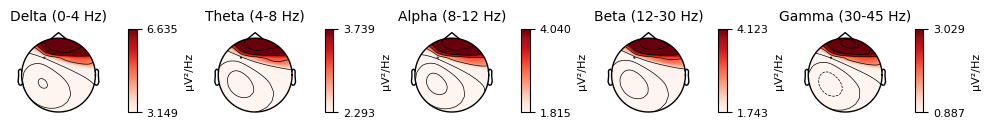

d:\Program Files\anaconda\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


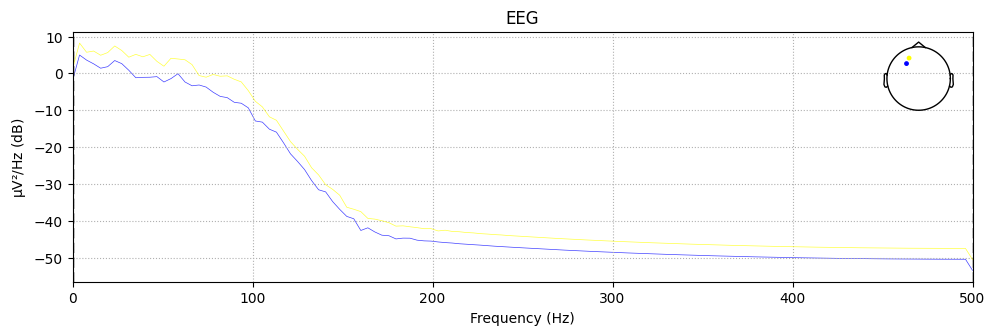

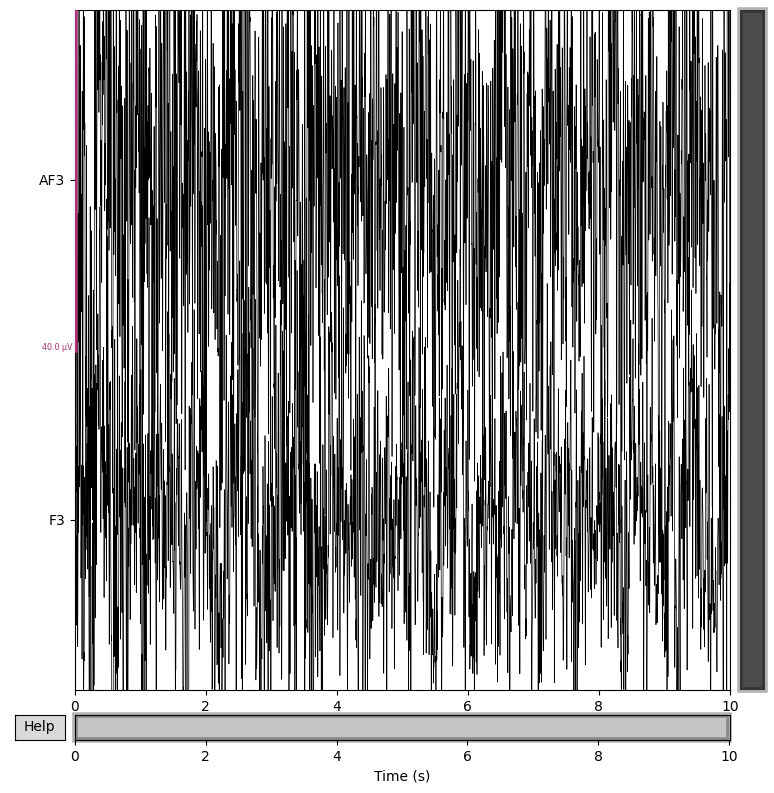

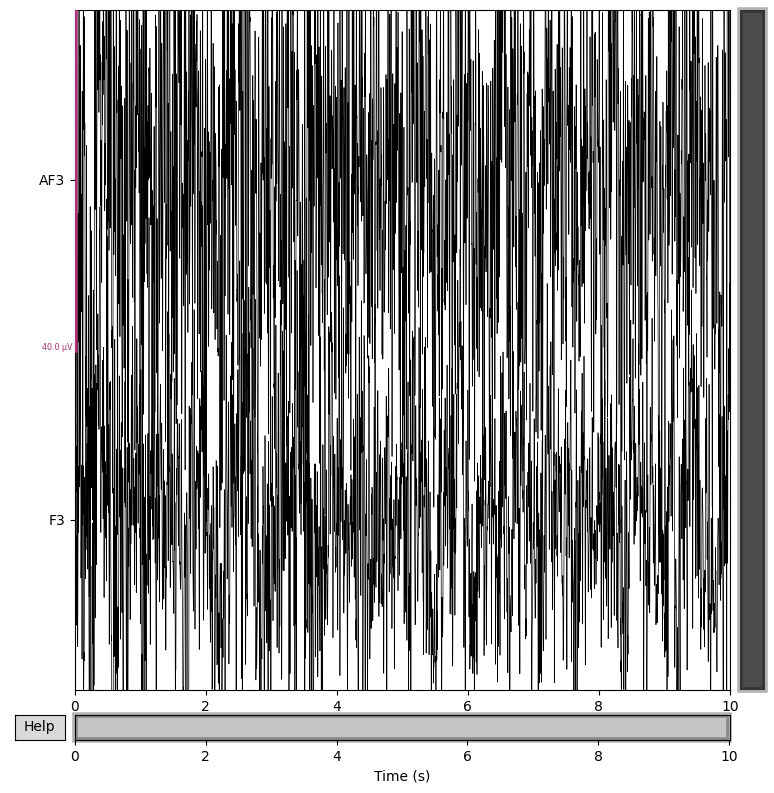

In [24]:
AF3_F3_psd = AF3_F3.compute_psd()

AF3_F3_psd.plot_topomap()
AF3_F3_psd.plot()
AF3_F3.plot()

There are multiple evidances that both of these channels ("AF3", "F3") are happening the **frontal lobe** such as:

- By looking at the topogram, we can see the dark area is around the frontal lobe
- Gamma oscillations in the frontal cortex have been associated with working memory and decision-making.

# Extracting slice of key activity

In [25]:
AF3_slice1 = df['AF3'][:1000]
F3_slice1 = df['F3'][:1000]

# Doing the same for another file

In [26]:
df2 = pd.read_csv('second.csv').T

ch_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']

col0 = list(df2.index)
df2.index = [i for i in range(df2.shape[0])]
df2.insert(0, 'Channel 0', col0)

col_names = list(df2.columns)
for i, name in enumerate(col_names):
    col_names[i] = ch_names[i]
df2.columns = col_names
df2

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,5.26126441754259e-07,0.000002,-2.320526e-06,-0.000005,-1.250564e-06,-1.183351e-06,0.000001,-0.000005,-0.000010,-0.000003,...,-3.943408e-06,-1.075747e-05,-2.854930e-06,-0.000005,-5.565573e-06,-0.000006,2.254013e-07,9.603496e-07,-0.000002,-3.486116e-06
1,-3.18715117486524e-06,-0.000002,-4.831538e-06,-0.000006,-3.064205e-06,-7.912727e-07,0.000002,-0.000007,-0.000012,-0.000004,...,-2.244248e-06,-2.781728e-05,-1.044503e-06,-0.000006,-3.798641e-06,-0.000005,5.608630e-06,8.032282e-06,0.000003,-1.121946e-07
2,-5.04165954163131e-06,-0.000004,-6.902253e-06,-0.000008,-4.584521e-06,-4.482601e-07,0.000003,-0.000009,-0.000014,-0.000005,...,-7.088315e-07,-4.197668e-05,9.850294e-08,-0.000006,-2.186811e-06,-0.000004,1.027538e-05,1.359412e-05,0.000006,2.565949e-06
3,-3.88397343380427e-06,-0.000006,-8.192750e-06,-0.000010,-5.593530e-06,-2.020191e-07,0.000004,-0.000011,-0.000015,-0.000005,...,5.618181e-07,-5.087121e-05,1.602898e-07,-0.000007,-8.352378e-07,-0.000003,1.373464e-05,1.665514e-05,0.000009,4.123769e-06
4,3.00768376878175e-07,-0.000006,-8.550024e-06,-0.000011,-6.005545e-06,-9.449147e-08,0.000004,-0.000014,-0.000016,-0.000005,...,1.547931e-06,-5.322636e-05,-8.560570e-07,-0.000007,2.257969e-07,-0.000002,1.584388e-05,1.708216e-05,0.000009,4.571486e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,-1.09871031997466e-05,-0.000020,1.314418e-05,0.000016,5.567291e-06,1.059985e-05,-0.000023,0.000013,0.000010,0.000004,...,2.574180e-06,1.040666e-05,2.067839e-07,-0.000003,-4.839513e-06,-0.000009,-9.726904e-06,-4.808536e-06,-0.000009,-1.084578e-05
9970,-9.88004202323089e-06,-0.000021,1.249781e-05,0.000014,4.766764e-06,9.401359e-06,-0.000018,0.000011,0.000008,0.000003,...,2.176170e-06,3.929622e-06,-9.745858e-07,-0.000004,-4.950942e-06,-0.000008,-8.600671e-06,-7.522693e-06,-0.000009,-1.024602e-05
9971,-1.08644454153813e-05,-0.000016,9.554023e-06,0.000012,3.612789e-06,7.515105e-06,-0.000014,0.000010,0.000007,0.000002,...,1.540783e-06,1.203338e-11,-2.810072e-06,-0.000004,-4.585664e-06,-0.000008,-7.376465e-06,-8.761126e-06,-0.000009,-8.921597e-06
9972,-1.37834409104257e-05,-0.000005,4.881128e-06,0.000009,2.181423e-06,5.021027e-06,-0.000010,0.000007,0.000006,0.000002,...,6.989045e-07,-5.946689e-07,-5.085026e-06,-0.000004,-3.785224e-06,-0.000007,-6.193804e-06,-8.437259e-06,-0.000007,-7.025338e-06


In [27]:
AF3_slice2 = df2['AF3'][:1000]
F3_slice2 = df2['F3'][:1000]

# Comparing extracted slices of key activity using statistical test

The statistical test that I am going to use is t-test. This test can be used to compare the means of two different groups, such as the mean power in a specific frequency band for two individuals.

Note: I will use gamma frequency band to evaluate the 2 slices on.

Here are the steps that I will follow to preform the test:

1. Calculate the band power for the selected channel in both individuals.

2. Use an independent-samples t-test to compare the means of the two groups. The null hypothesis is that the mean band power is the same for both individuals, and the alternative hypothesis is that the mean band power is different between the individuals.

3. Check the assumptions of the t-test.

4. If the assumptions are met, I will perform the t-test and report the p-value and effect size. If the p-value is less than the significance level (e.g., 0.05), I will reject the null hypothesis and conclude that there is a significant difference in the mean band power between the two individuals.

In [15]:
import numpy as np
from scipy.stats import ttest_ind

data1 = [AF3_slice1, F3_slice1]
data2 = [AF3_slice2, F3_slice2]

freq_band = [25, 140]

# Compute the band power for each individual and channel
band_power1 = np.zeros((2,))
band_power2 = np.zeros((2,))

for ch in range(2):
    band_power1[ch] = bandpower(data1[ch], 1000, freq_band, 5, True)
    band_power2[ch] = bandpower(data2[ch], 1000, freq_band, 5, True)

# Perform the independent-samples t-test
stat, p = ttest_ind(band_power1, band_power2)
if p < 0.05:
    print('Significant difference in mean gamma power (p = %f)' % p)
else:
    print('No significant difference in mean gamma power (p = %f)' % p)

# Compute effect size (Cohen's d)
mean_diff = np.mean(band_power1) - np.mean(band_power2)
std_pooled = np.sqrt((np.std(band_power1) ** 2 + np.std(band_power2) ** 2) / 2)
d = mean_diff / std_pooled
print('Cohen\'s d = %f' % d)


No significant difference in mean gamma power (p = 0.503686)
Cohen's d = -1.143391


d:\Program Files\anaconda\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 5000 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


Given that the Cohen's d value is -1.143391, this mean that the standard deviations is trivial as it is smaller than 0.2 which also mean that the effect size is insignificant